# Apprenticeship Learning via IRL - Q Learning

In [1]:
import gym
import numpy as np
from tqdm import tqdm
import imageio
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, Image

from q_learn_pendulum import QTrainer

## Pendulum-v0

Description:
- The inverted pendulum swingup problem is a classic challenge in control theory.
- It consists of a pendulum attached at one end to a fixed point, with the other end free to move.

\
Objective: The goal is to swing the pendulum from a random position to an upright position, where its center of gravity is directly above the fixed point.

\
Observations

Num | Observation | Min | Max
---|---|---|---
0 | x = cos(theta) | -1.0 | 1.0
1 | y = sin(angle) | -1.0 | 1.0
2 | Angular Velocity |-8.0 | 8.0

\
Actions:
Num | Action | Min | Max
--- | --- | --- | ---
0 | Torque | -2.0 | 2.0

\
The reward function is defined as:

r = -(θ^2 + 0.1 * θ_dt^2 + 0.001 * torque^2)

where θ is the pendulum’s angle normalized between [-π, π] (with 0 being in the upright position). 

Based on the above equation, 
- The minimum reward that can be obtained is -(π^2 + 0.1 * 8^2 + 0.001 * 2^2) = -16.2736044.
- The maximum reward is 0, indicating the pendulum is upright with zero velocity and no torque applied.


Environment: Pendulum-v0

Observation Space: Box(3,)

Action Space:  Box(1,)

Initial State:  [-0.99549406  0.09482391 -0.61459334]

A step in the env: (array([-0.99306846,  0.11753737, -0.45686208]), -9.320046749413747, False, {})


Rendered Environment: 


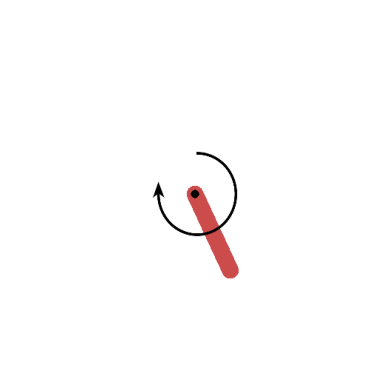

In [2]:
env = gym.make('Pendulum-v0', g=9.81)
print('\nEnvironment: Pendulum-v0')
print('\nObservation Space:', env.observation_space)
print('\nAction Space: ', env.action_space)
print('\nInitial State: ',env.reset())
print('\nA step in the env:', env.step(env.action_space.sample()))
print('\n\nRendered Environment: ')
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'))
env.close()
plt.show()

## Training - Obtain Expert Policy

1. **Agent Initialization:**
   - Initialize an agent for Q-learning.

2. **Q-Table Initialization:**
   - Create a Q-table to represent the policy.
   - Dimensions: 10000 x 2 (states x actions).
   - Initialize rewards in the Q-table.

3. **Training with Q-Learning:**
   - Utilize an epsilon-greedy strategy to choose actions during training.
   - Explore with probability ε and exploit with probability 1-ε.

4. **Update Q-Table:**
   - Update Q-values iteratively based on the Q-learning update rule.
   - Q-value for a state-action pair is a weighted sum of the immediate reward and the maximum expected future rewards.

5. **Exploration and Exploitation:**
   - Balance exploration and exploitation through the epsilon-greedy strategy.
   - Exploration allows discovering optimal actions, while exploitation focuses on maximizing immediate rewards.

6. **Iterative Training:**
   - Repeat the training process over multiple episodes or iterations.

7. **Policy:**
   - The Q-table represents the learned policy, with each row corresponding to a state and each column to an action.

8. **Expert Policy for IRL:**
   - The trained Q-learning agent serves as an expert policy for Inverse Reinforcement Learning (IRL).

- The Q-learning algorithm aims to iteratively improve the policy by updating Q-values based on observed rewards, guiding the agent toward optimal actions in different states.

In [3]:
q_trainer = QTrainer(env, discrete_space_size=[21, 21, 65], discrete_act_size=9, GAMMA=0.95, ALPHA=0.1)

print('\nNo. of actions after discretization: ', len(q_trainer.action_space))
print('\nAction Space: ', q_trainer.action_space.values())


No. of actions after discretization:  9

Action Space:  dict_values([[-2.0], [-1.5], [-1.0], [-0.5], [0.0], [0.5], [1.0], [1.5], [2.0]])


In [4]:
# Training

episode_rewards, expert_Q = q_trainer.q_learning_train(num_episodes=40000, 
                                                       print_interval=40000, 
                                                       save_q_path='./data/expert_Q_Table.npy',
                                                       render_save_path='../Results/Q Learning - Pendulum/expert_training')

Training Episodes..: 100%|███████████████| 40000/40000 [03:47<00:00, 175.75it/s]

Episode: 40000, Reward: -123.80526833148998


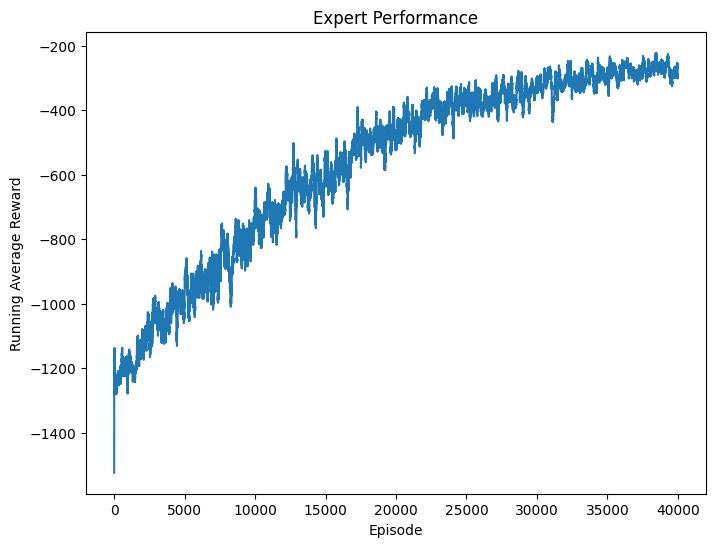

In [5]:
# Plot performance

q_trainer.plot_performance(episode_rewards,title="Expert Performance",save=True,
                 filename='../Results/Q Learning - Pendulum/Expert Performance')

Running Policy...: 100%|███████████████████| 1000/1000 [00:03<00:00, 313.46it/s]


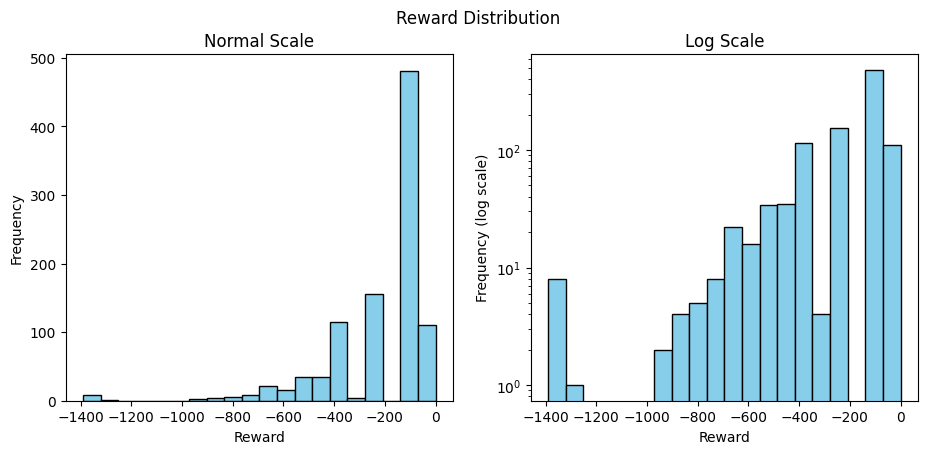

In [6]:
# Training result
# Using the learned policy, simulate the environment 1000 times to sample the reward distribution.

expert_rewards = q_trainer.run_policy(num_episodes=1000, render=False)
q_trainer.plot_reward_dist(expert_rewards)

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


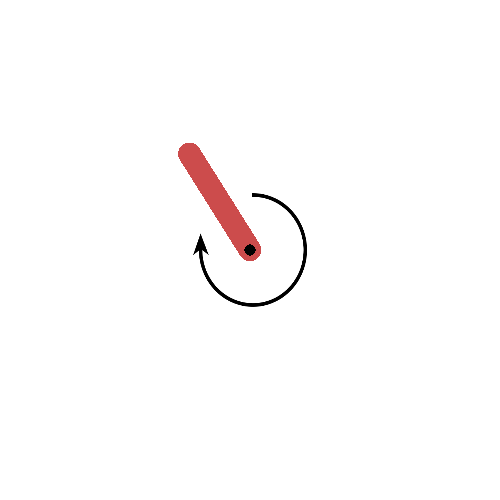

Expert Reward -  [-124.79653899107672]


In [15]:
# Visualize policy in action

expert_reward = q_trainer.run_policy(expert_Q, num_episodes=1, 
                           render=True, render_filename='../Results/Q Learning - Pendulum/Expert Policy')
print('Expert Reward - ',expert_reward)

# IRL Algorithm

* We define some functions for the Apprenticeship Inverse Reinforcement Learning (IRL) algorithm based on the paper by  P. Abbeel and A. Y. Ng titled "Apprenticeship Learning via Inverse Reinforcement Learning."

* To train new agents, instead of utilizing the (predefined) returned reward from the training environment, it incorporates the reward function of the expert derived from the IRL algorithm. This reward function involves a weight term (w) and observation space (Φ(s)) obtained through the IRL algorithm.

* To ensure observation features fall within the [0, 1] range for computing feature expectations, sigmoid function is applied to each element of the feature vector.

In [8]:
def compute_feature_expectation(env, Q, agent, m=1000):
    """
    Compute the average feature expectation using the provided Q-table and environment (Monte Carlo Estimation).

    Parameters:
    - env: Environment
    - Q: Q-table representing the policy.
    - agent: Trainer Class used to train agent.
    - m: Number of trajectories for feature calculation.

    Returns:
    - feature_expectation: Computed average feature expectation.
    """
    observation_sum = np.zeros(len(env.reset()))
    gamma = agent.GAMMA

    for _ in tqdm(range(m), desc='Calculating Feature Expectation..'):
        observation = env.reset()
        done = False
        count = 0

        while not done:
            state = agent.discretize_state(observation)
            action = np.argmax(Q[state])
            torque = agent.action_space[action]
            observation, reward, done, _ = env.step(torque)
            
            # apply sigmoid function to observation features
            observation = agent.sigmoid(observation)

            # accumulate discounted observation features
            observation_sum += (gamma ** count) * observation  # Σ γ^t * φ
            count += 1

    # average feature expectation
    feature_expectation = observation_sum / m

    print("Feature Expectation:", feature_expectation)
    
    return feature_expectation

In [9]:
# get feature expectation of expert

expert_Q = np.load('./data/expert_Q_Table.npy')
    
expert_expectation = compute_feature_expectation(env, Q=expert_Q, agent=q_trainer, m=4000)

Calculating Feature Expectation..: 100%|███| 4000/4000 [00:15<00:00, 263.17it/s]

Feature Expectation: [ 8.09353376 10.07769328 10.50884957]


## IRL algorithm using Projection method

1. **Initialization:**
   - Randomly pick an initial policy, denoted as π(0).
   - Compute the feature expectation, µ(0), using Monte Carlo or other approximation methods.
   - Set iteration counter i = 1.

2. **Margin Computation:**
   - Compute the margin, t(i), as the maximum margin between the current feature expectation and those of previous policies.
   - Compute margin using projection method to find the optimal weight vector w(i).

3. **Termination Check:**
   - If the margin t(i) is less than or equal to a predefined threshold ε, terminate the algorithm.

4. **IRL Training:**
   - Use a Reinforcement Learning (RL) algorithm to compute the optimal policy π(i) for the Markov Decision Process (MDP) with rewards defined by the weight vector w(i).

5. **Update Feature Expectation:**
   - Compute or estimate the feature expectation, µ(i), based on the new policy π(i).

6. **Iteration Update:**
   - Increment the iteration counter i.

7. **Repeat:**
   - Return to step 2 and iterate through the process until the termination condition is met.

Upon termination, the algorithm returns a set of policies {π(i) : i = 0 . . . n}, representing a sequence of policies that approximate the expert's behavior.

In [10]:
def projection_method_algorithm(agent=q_trainer, expert_expectation=expert_expectation, epsilon=0.0001, iterations=10, 
                                m=1000, n_episodes=10000):
    """
    Function implementing Apprenticeship Learning IRL algorithm using Projection Method.
    
    Parameters:
        agent (QTrainer): An instance of a Q-learning trainer with IRL training.
        epsilon (float, optional): Termination threshold for the margin.
        iterations (int, optional): Maximum number of iterations.

    Returns:
        Tuple: A tuple containing the following elements:
            - List[QValues]: Learned Q-values for each iteration.
            - List[avg_episode_rewards]: Average episode lengths during training.
            - List[margins]: Margins for each iteration.
    """
    weights = []
    feature_expectation = []
    feature_expectation_bar = []
    learned_Qs = []
    margins = []
    avg_episode_rewards = []

    for i in range(iterations+1):
        print(f"\n------------------------------ Iteration: {i} ------------------------------\n")

        # Step 1: Initialization
        if i == 0:
            initial_Q = agent.init_Q()  # Random initial policy
            feature_expectation.append(compute_feature_expectation(env, initial_Q, q_trainer, m=m))   # µ^(0)
            print("Expert Feature Expectation:", expert_expectation)             # µ_E
            learned_Qs.append(initial_Q)
            weights.append(np.random.rand(4))
            margins.append(np.random.rand())

        else:
            # Step 2: IRL
            # First iteration of step 2 of algorithm
            if i == 1:
                feature_expectation_bar.append(feature_expectation[i - 1])       # µ¯^(0) = µ^(0)
                weights.append(expert_expectation - feature_expectation[i - 1])   # w^(1) = µ_E - µ^(0)
                margins.append(np.linalg.norm((expert_expectation - feature_expectation_bar[i - 1]), 2))
                print("Weight:", weights[i])
                print("Margin:", margins[i])

            # Iterations 2 and onward of step 2 of algorithm
            else:
                A = feature_expectation_bar[i - 2]              # µ¯(i−2)
                B = feature_expectation[i - 1] - A              # (µ(i−1) − µ¯(i−2))
                C = expert_expectation - A                      # µ_E − µ¯(i−2)

                feature_expectation_bar.append(A + (np.dot(B, C) / np.dot(B, B)) * B)  # projection method step

                # w(i) = µ_E − μ¯(i−1)
                weight = expert_expectation - feature_expectation_bar[i - 1]

                # t(i) = ∥µ_E − µ¯(i−1)∥_2
                margin = np.linalg.norm((expert_expectation - feature_expectation_bar[i - 1]), 2)
                
                weights.append(weight)
                margins.append(margin)
                
                print("Margin:", margins[i])
                print("Weight:", weights[i])

            # Step 3: Termination condition
            if margins[i] <= epsilon:
                print('Margin reached the value of epsilon.')
                break                   # terminate with margin ≤ ∈ (or iteration)

            # Step 4: IRL training
            episode_rewards, learned_Qs_i = agent.q_learning_train(irl=True, num_episodes=n_episodes,
                                                                                       weight=weights[i], 
                                                                                       print_interval=100000)
            learned_Qs.append(learned_Qs_i)
            avg_episode_rewards.append(np.average(episode_rewards))
            
            agent.plot_performance(episode_rewards, title=f"Performance of Apprentice {i}", save=True, 
                     filename=f"../Results/Q Learning - Pendulum/Apprentice_{i}_Performance")
            
            apprentice_reward = agent.run_policy(learned_Qs_i, num_episodes=1, render=True, 
                                             render_filename=f'../Results/Q Learning - Pendulum/Apprentice {i} Policy')
            print(f'Reward of Apprentice {i} - ', apprentice_reward)

            # Step 5: Update feature expectation
            feature_expectation.append(compute_feature_expectation(env, learned_Qs[i], q_trainer, m=m))

        print("")
        
    return learned_Qs, avg_episode_rewards, margins


------------------------------ Iteration: 0 ------------------------------



Calculating Feature Expectation..: 100%|███| 4000/4000 [00:15<00:00, 264.12it/s]


Feature Expectation: [ 8.05007214 10.19588561  9.60701278]
Expert Feature Expectation: [ 8.09353376 10.07769328 10.50884957]


------------------------------ Iteration: 1 ------------------------------

Weight: [ 0.04346162 -0.11819233  0.90183679]
Margin: 0.9105865866999862


Training Episodes..: 100%|███████████████| 20000/20000 [01:48<00:00, 184.91it/s]


Avg Reward: -1236.8336051181202 
Standard Deviation: 311.209601830938


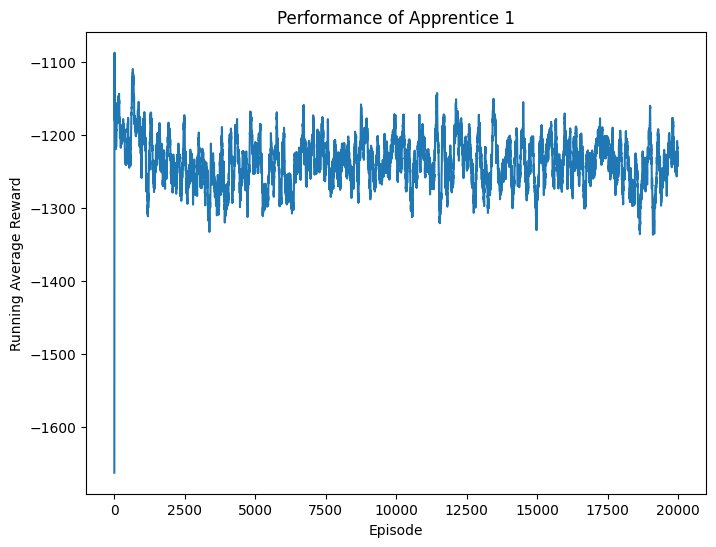

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


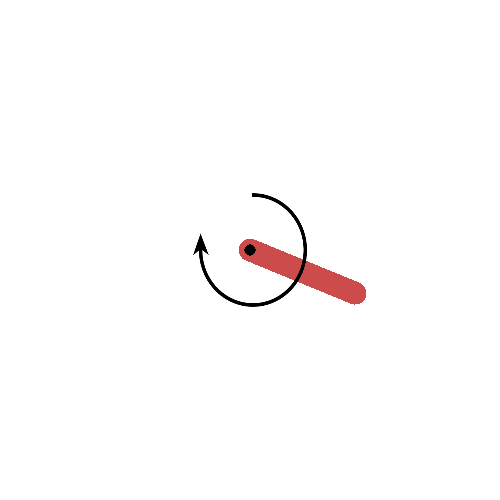

Reward of Apprentice 1 -  [-1555.9308963764195]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:14<00:00, 272.77it/s]


Feature Expectation: [ 8.27902965 10.09429724  8.78385809]


------------------------------ Iteration: 2 ------------------------------

Margin: 0.3580083455904607
Weight: [ 0.26625483 -0.2170456   0.10084417]


Training Episodes..: 100%|███████████████| 20000/20000 [01:55<00:00, 172.89it/s]


Avg Reward: -1069.7469424861763 
Standard Deviation: 437.2702547484811


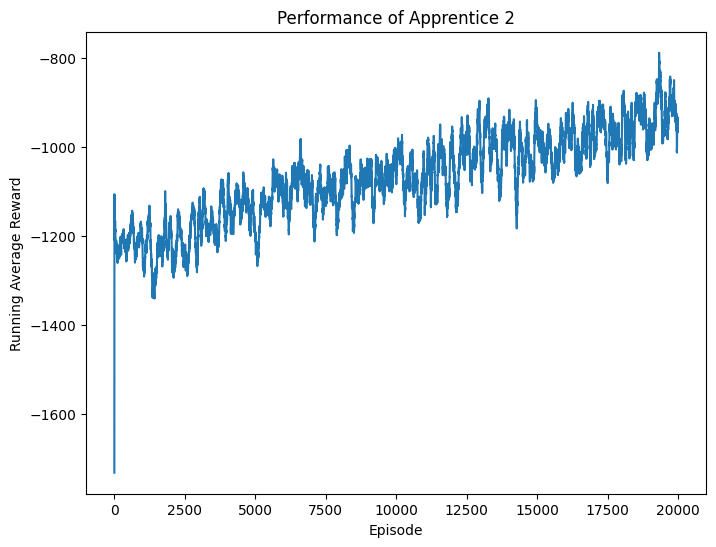

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


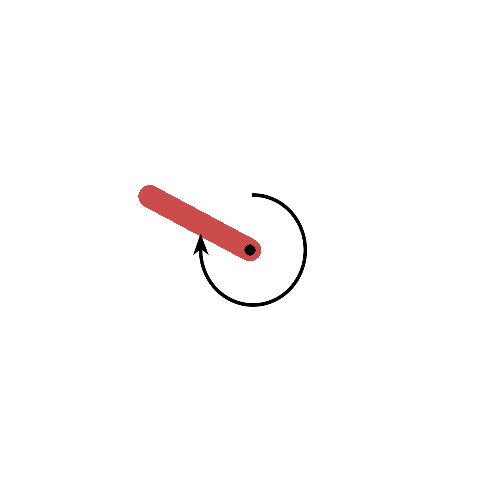

Reward of Apprentice 2 -  [-254.98181764387277]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:16<00:00, 245.35it/s]


Feature Expectation: [ 8.7110319  10.1399923   9.76608804]


------------------------------ Iteration: 3 ------------------------------

Margin: 0.3064676912272151
Weight: [ 0.11800439 -0.19108671  0.20852645]


Training Episodes..: 100%|███████████████| 20000/20000 [01:53<00:00, 176.11it/s]


Avg Reward: -1253.4257301960517 
Standard Deviation: 284.59273098901576


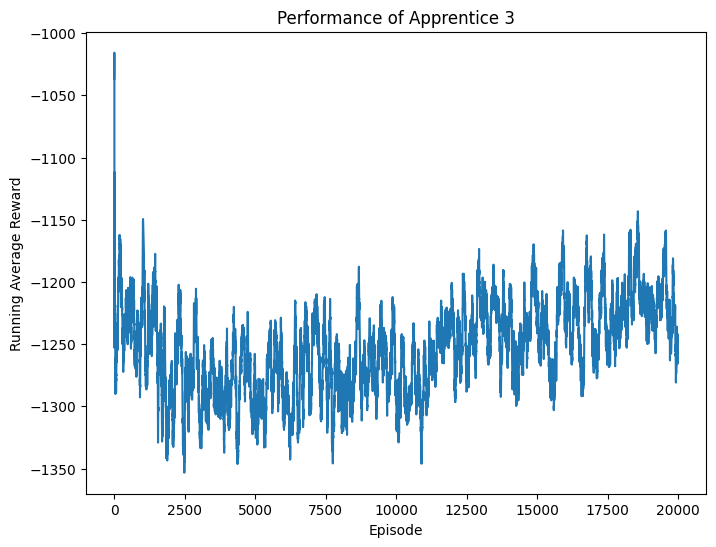

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


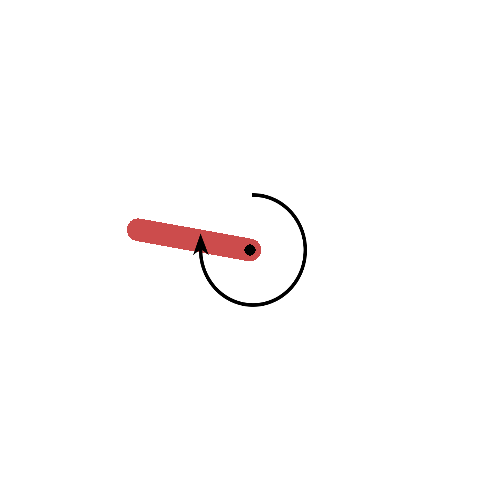

Reward of Apprentice 3 -  [-1313.327707570677]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:14<00:00, 279.60it/s]


Feature Expectation: [ 8.42706855 10.01932319  9.95592826]


------------------------------ Iteration: 4 ------------------------------

Margin: 0.3028463396624587
Weight: [ 0.08380829 -0.17219477  0.23460827]


Training Episodes..: 100%|███████████████| 20000/20000 [01:43<00:00, 192.84it/s]


Avg Reward: -1269.2031520592982 
Standard Deviation: 308.6011420733971


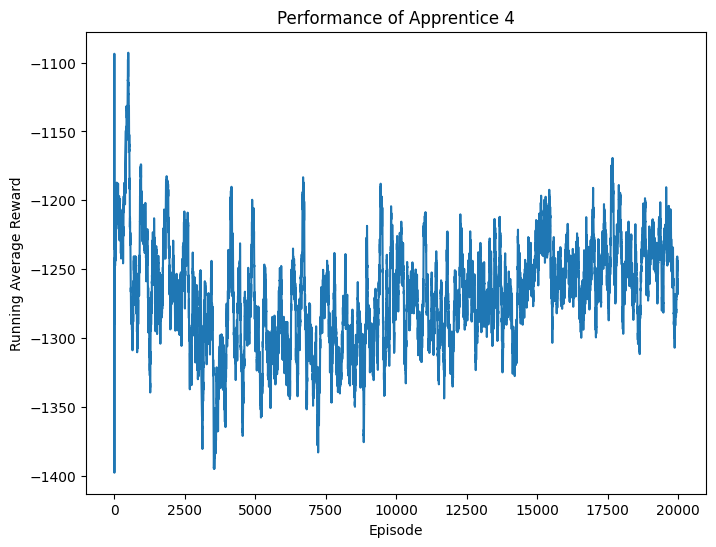

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


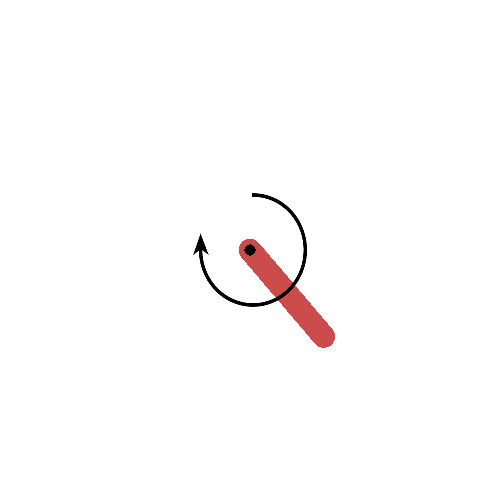

Reward of Apprentice 4 -  [-1546.0663765129755]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:15<00:00, 252.99it/s]


Feature Expectation: [ 8.56178369 10.20991062  9.56565552]


------------------------------ Iteration: 5 ------------------------------

Margin: 0.2754936676533352
Weight: [ 0.16103135 -0.17778689  0.1354898 ]


Training Episodes..: 100%|███████████████| 20000/20000 [01:51<00:00, 179.26it/s]


Avg Reward: -1276.4111995891049 
Standard Deviation: 331.274006824686


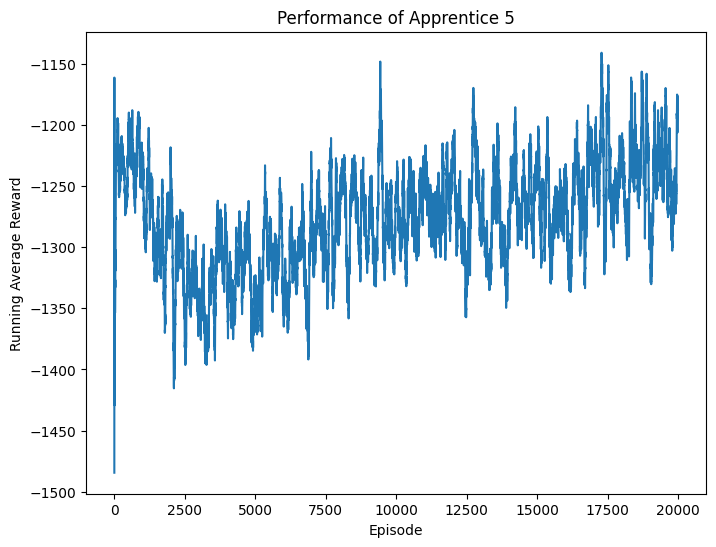

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


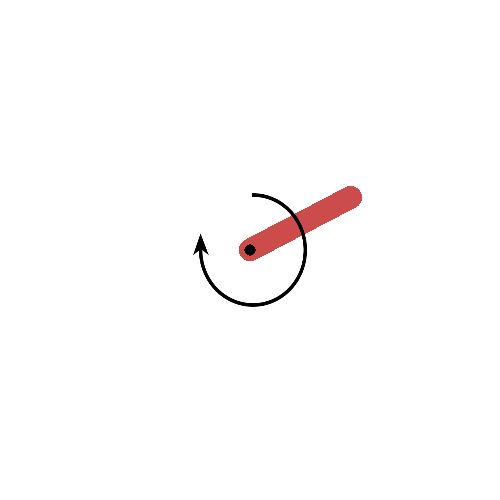

Reward of Apprentice 5 -  [-853.3851950668256]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:15<00:00, 257.14it/s]


Feature Expectation: [ 8.43280305  9.97234615 10.76438458]


------------------------------ Iteration: 6 ------------------------------

Margin: 0.07710255263237224
Weight: [-0.02929238 -0.07007741 -0.01326336]


Training Episodes..: 100%|███████████████| 20000/20000 [01:50<00:00, 180.37it/s]


Avg Reward: -1231.7223577582338 
Standard Deviation: 219.71928470712106


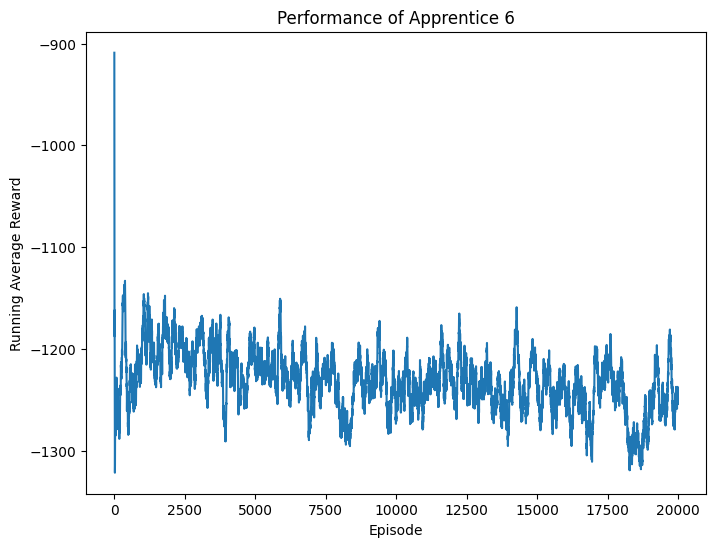

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


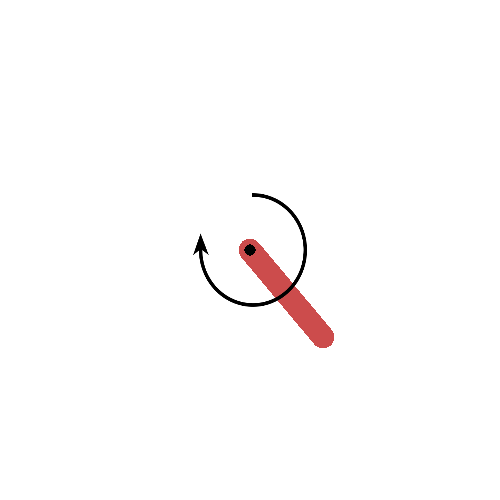

Reward of Apprentice 6 -  [-1598.5448723185805]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:15<00:00, 261.91it/s]


Feature Expectation: [ 8.00740851  9.96791654 10.02688775]


------------------------------ Iteration: 7 ------------------------------

Margin: 0.06477977577668653
Weight: [-0.02034479 -0.05613446  0.02512829]


Training Episodes..: 100%|███████████████| 20000/20000 [01:49<00:00, 182.23it/s]


Avg Reward: -1294.565009348305 
Standard Deviation: 238.08667568583496


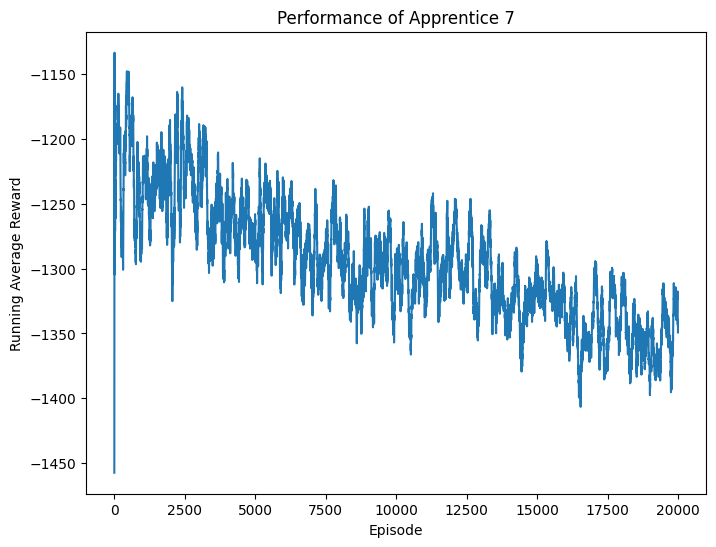

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


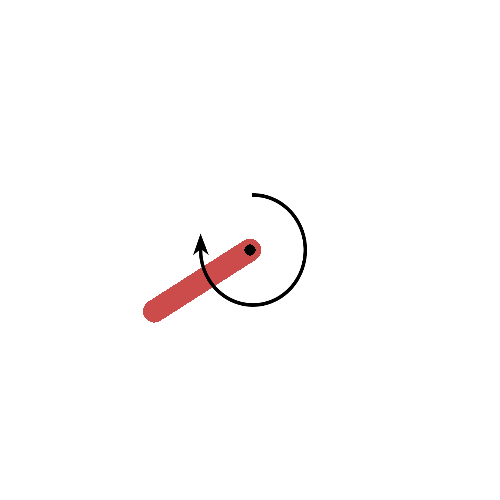

Reward of Apprentice 7 -  [-1502.711156507811]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:15<00:00, 255.85it/s]


Feature Expectation: [ 8.49687123 10.02836743  9.37991167]


------------------------------ Iteration: 8 ------------------------------

Margin: 0.059660620669049355
Weight: [-0.01210474 -0.05840343  0.00137996]


Training Episodes..: 100%|███████████████| 20000/20000 [01:49<00:00, 181.96it/s]


Avg Reward: -1231.7025519077854 
Standard Deviation: 233.6204805133356


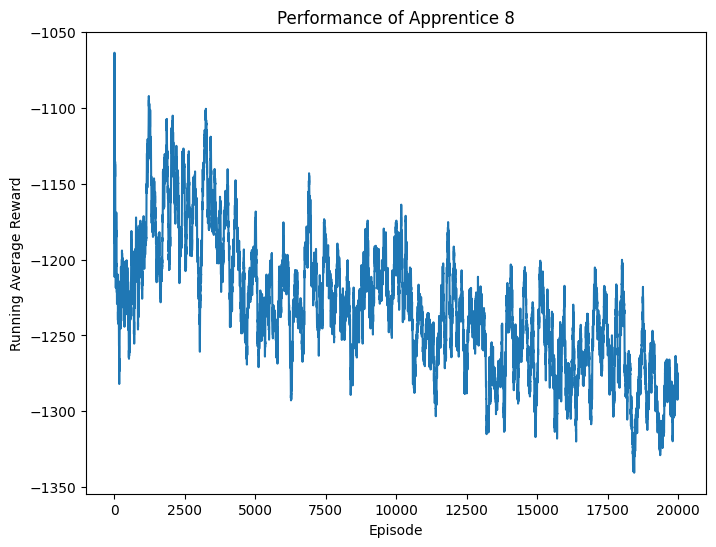

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.32s/it]


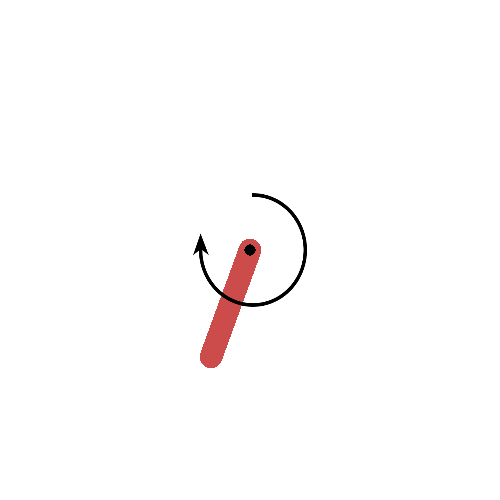

Reward of Apprentice 8 -  [-1473.8388022452496]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:15<00:00, 257.76it/s]


Feature Expectation: [ 8.58404576 10.14656369 10.74047764]


------------------------------ Iteration: 9 ------------------------------

Margin: 0.05855647508830534
Weight: [-0.00183531 -0.05817875  0.00638168]


Training Episodes..: 100%|███████████████| 20000/20000 [01:48<00:00, 185.04it/s]


Avg Reward: -1238.7563750364438 
Standard Deviation: 225.35665324865693


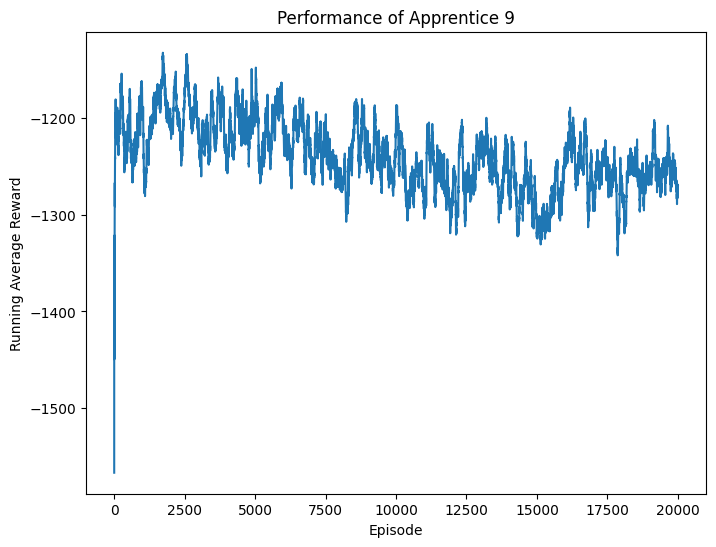

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


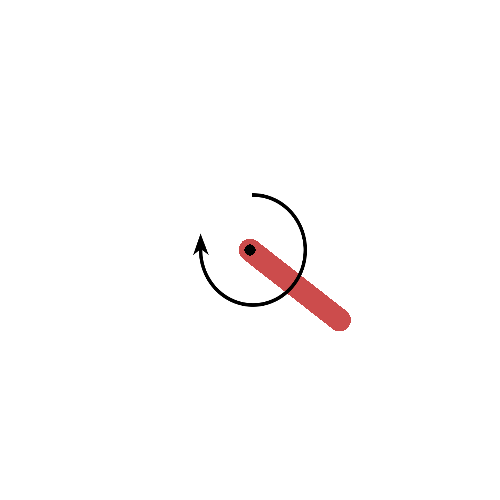

Reward of Apprentice 9 -  [-1507.5342735647016]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:14<00:00, 268.59it/s]


Feature Expectation: [ 8.72685208  9.94822757 10.10879893]


------------------------------ Iteration: 10 ------------------------------

Margin: 0.057790313150427215
Weight: [-0.00960418 -0.05587024  0.01122482]


Training Episodes..: 100%|███████████████| 20000/20000 [01:43<00:00, 192.96it/s]


Avg Reward: -1265.8973387549795 
Standard Deviation: 231.34818137653983


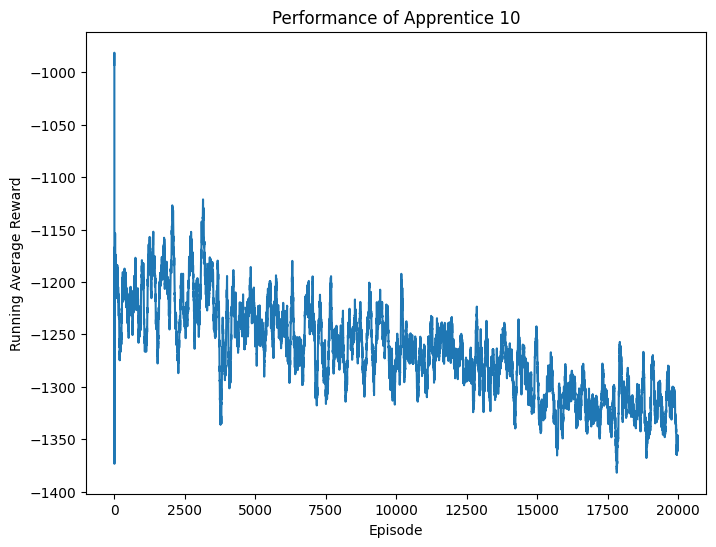

Running Policy...: 100%|██████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


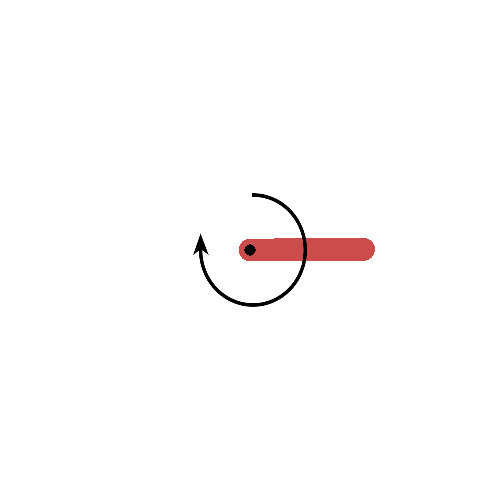

Reward of Apprentice 10 -  [-1469.032600963065]


Calculating Feature Expectation..: 100%|███| 4000/4000 [00:14<00:00, 271.70it/s]

Feature Expectation: [ 7.92470003  9.47119362 10.33784287]



In [11]:
learned_Qs, avg_episode_rewards, margins = projection_method_algorithm(q_trainer, epsilon=0.02, iterations=10, 
                                                                       m=4000, n_episodes=20000)

In [12]:
# export trained IRL models
with open('./data/Learned_Q_tables', 'wb') as f:
    pickle.dump(learned_Qs, f)
    print(f'Saved Learned Q Tables')

Saved Learned Q Tables


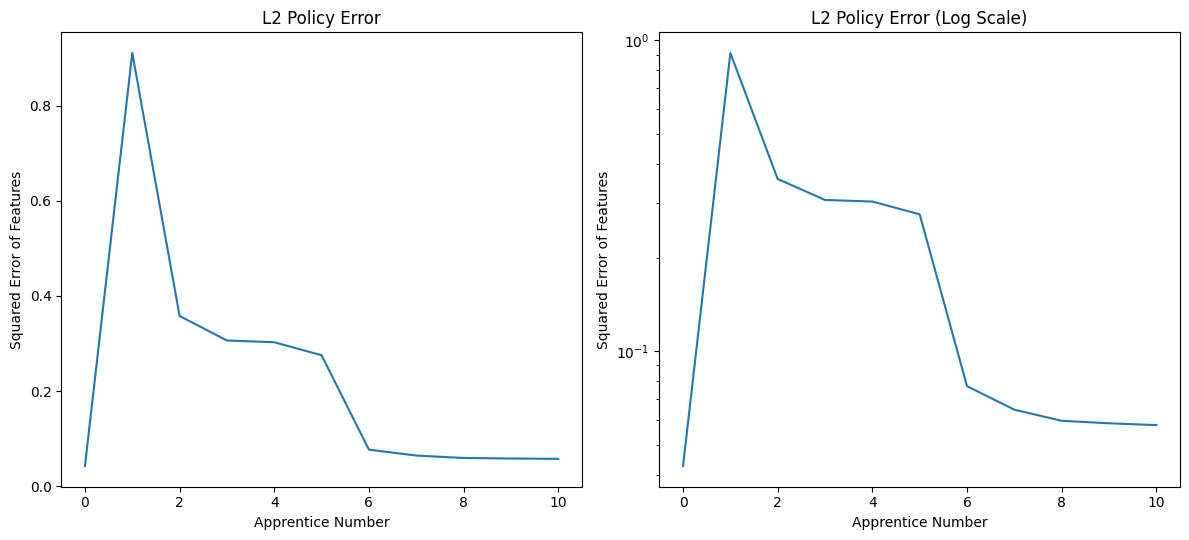

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5.5))

# plot without log scale
axes[0].plot(margins, label="L2 Policy Error")
axes[0].set_title("L2 Policy Error")
axes[0].set_xlabel("Apprentice Number")
axes[0].set_ylabel("Squared Error of Features")

# plot with log scale
axes[1].plot(margins, label="L2 Policy Error")
axes[1].set_title("L2 Policy Error (Log Scale)")
axes[1].set_xlabel("Apprentice Number")
axes[1].set_ylabel("Squared Error of Features")
axes[1].set_yscale("log")

plt.tight_layout()
plt.savefig("../Results/Q Learning - Pendulum/Apprentice Policy Error.png")
plt.show()

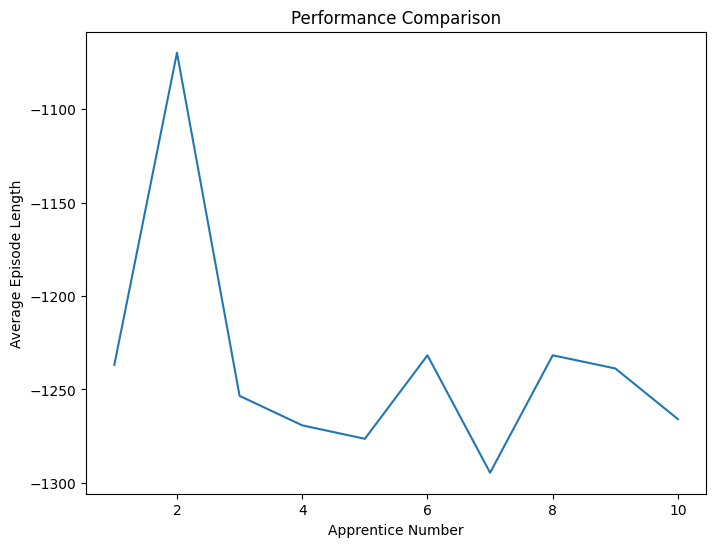

In [14]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(avg_episode_rewards)+1),avg_episode_rewards)
plt.xlabel("Apprentice Number")
plt.ylabel("Average Episode Length")
plt.title("Performance Comparison")
plt.savefig("../Results/Q Learning - Pendulum/Apprentice Rewards.png")
plt.show()